# 房價預測



- 來源：[Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)
- 目標：SalePrice 房價（美金）


In [5]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import os
from scipy import stats
from scipy.stats import norm, skew 

plt.rc("font",family="SimHei",size="15") 

%matplotlib inline 

In [6]:
df_train = pd.read_csv("data2/train.csv")
df_test = pd.read_csv('data2/test.csv')

df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [8]:

df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

findfont: Font family ['SimHei'] not found. Falling back to DejaVu Sans.


<Figure size 1600x500 with 0 Axes>

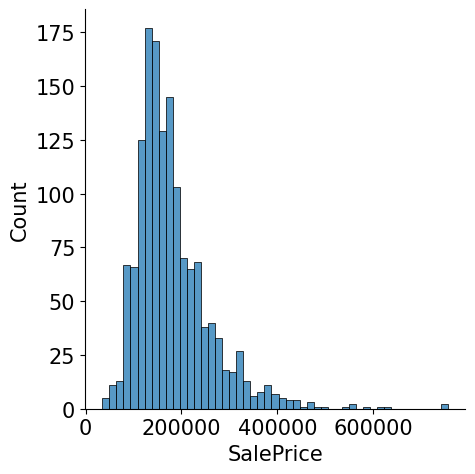

In [9]:
plt.figure(figsize=(16, 5))
sns.displot(df_train['SalePrice'],kde=False)  

In [10]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


<AxesSubplot:>

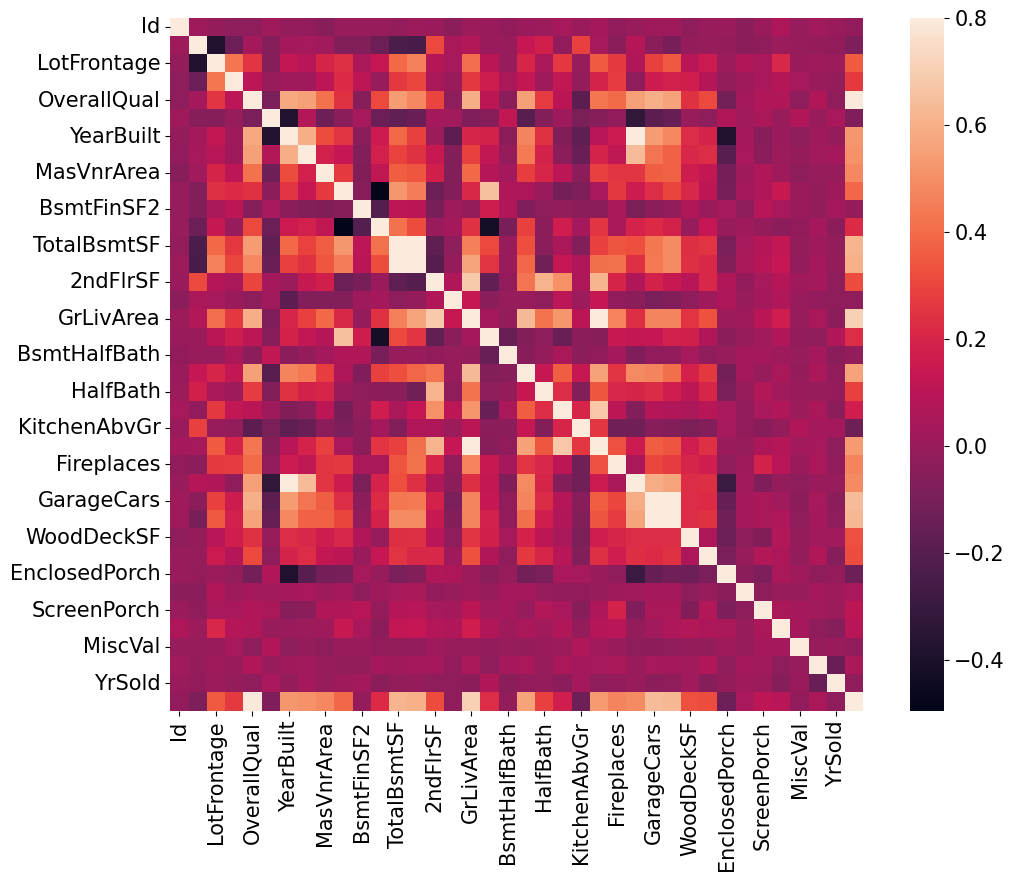

In [11]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [74]:
print(df_train["SalePrice"])

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64


# Impute and Preprocessing

In [12]:
def missing(data,num=10):
    null_data = data.isnull().sum().sort_values(ascending=False)
    percent_1 = data.isnull().sum()/data.isnull().count()
    missing_data = pd.concat([null_data,percent_1.apply(lambda x: format(x, '.2%'))],axis=1,keys=['total missing','missing percentage'])
    print(missing_data.head(num))

missing(df_train, 15)


              total missing missing percentage
PoolQC                 1453             99.52%
MiscFeature            1406             96.30%
Alley                  1369             93.77%
Fence                  1179             80.75%
FireplaceQu             690             47.26%
LotFrontage             259             17.74%
GarageYrBlt              81              5.55%
GarageCond               81              5.55%
GarageType               81              5.55%
GarageFinish             81              5.55%
GarageQual               81              5.55%
BsmtFinType2             38              2.60%
BsmtExposure             38              2.60%
BsmtQual                 37              2.53%
BsmtCond                 37              2.53%


In [13]:
df_train.drop(["PoolQC","MiscFeature","Alley","Fence"], axis=1, inplace=True)
missing(df_train,5) 


              total missing missing percentage
FireplaceQu             690             47.26%
LotFrontage             259             17.74%
GarageType               81              5.55%
GarageYrBlt              81              5.55%
GarageFinish             81              5.55%


In [14]:
numeric = df_train.dtypes[df_train.dtypes == "int64"]
object_ = df_train.dtypes[df_train.dtypes == "object"]

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

df_train['LotShape'] = df_train['LotShape'].replace(['Reg', 'IR1', 'IR2', 'IR3'], [0,1,2,3])
df_train['LandContour'] = df_train['LandContour'].replace( ['Lvl', 'Bnk', 'Low', 'HLS'],[0,1,-1,2])
df_train['Street'] = df_train['Street'].replace(['Pave', 'Grvl'], [0,1])
df_train['MSZoning'] = df_train['MSZoning'].replace(['RL', 'RM', 'C (all)', 'FV', 'RH'], [2,1,0,3,1])
df_train.drop("Utilities",axis = 1, inplace = True)
df_train['LotConfig'] = df_train['LotConfig'].replace(['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3'], [0,0,0,1,1])
df_train['MSZoning'] = df_train['MSZoning'].replace(['RL', 'RM', 'C (all)', 'FV', 'RH'], [2,1,0,3,1])

###太多了寫不完

In [16]:
def check_Cate_mean_price(col):
    ele = list(df_train[col].unique())
    print(df_train[col] .value_counts())
    print()
    for j in ele :
        print(j,np.mean([df_train["SalePrice"][i] for i in range(1460) if df_train[col][i] == j]))
    
    return ele


col = "LotConfig"
check_Cate_mean_price(col)


Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

Inside 176938.0475285171
FR2 177934.5744680851
Corner 181623.4258555133
CulDSac 223854.6170212766
FR3 208475.0


['Inside', 'FR2', 'Corner', 'CulDSac', 'FR3']

In [17]:
df_train['MSSubClass'] = df_train['MSSubClass'].apply(str)
df_train['OverallCond'] = df_train['OverallCond'].astype(str)
df_train['YrSold'] = df_train['YrSold'].astype(str)
df_train['MoSold'] = df_train['MoSold'].astype(str)

In [18]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond','HeatingQC',  'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional',  'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street',  'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')

for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(df_train[c].values))
    df_train[c] = lbl.transform(list(df_train[c].values)) 

In [19]:
df_train['TotalSF'] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

In [20]:
df_train = pd.get_dummies(df_train)
print(df_train.shape)
df_train.head()

(1460, 216)


,Id,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,9,65.0,8450,1,3,0,7,4,2003,...,0,0,0,1,0,0,0,0,1,0
1,2,4,80.0,9600,1,3,0,6,7,1976,...,0,0,0,1,0,0,0,0,1,0
2,3,9,68.0,11250,1,0,0,7,4,2001,...,0,0,0,1,0,0,0,0,1,0
3,4,10,60.0,9550,1,0,0,7,4,1915,...,0,0,0,1,1,0,0,0,0,0
4,5,9,84.0,14260,1,0,0,8,4,2000,...,0,0,0,1,0,0,0,0,1,0


In [21]:
df_train.drop("Id",axis=1,inplace=True)

### MICE

In [98]:
from sklearn.model_selection import train_test_split
X = df_train.drop("SalePrice" , axis=1)
y = df_train["SalePrice"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print(y_train)

615     137500
613     147000
1303    232000
486     156000
561     170000
         ...  
1095    176432
1130    135000
1294    115000
860     189950
1126    174000
Name: SalePrice, Length: 978, dtype: int64


In [99]:
names = list(X_train.columns)
len(names)

214

In [100]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

mice = IterativeImputer(random_state=42)

X_train = pd.DataFrame(mice.fit_transform(X_train))
X_test = pd.DataFrame(mice.transform(X_test))

In [101]:
missing(X_train, 5)
missing(X_test, 5)

     total missing missing percentage
0                0              0.00%
134              0              0.00%
136              0              0.00%
137              0              0.00%
138              0              0.00%
     total missing missing percentage
0                0              0.00%
134              0              0.00%
136              0              0.00%
137              0              0.00%
138              0              0.00%


In [102]:
from sklearn.preprocessing import RobustScaler 

scaler = RobustScaler ()

X_train = pd.DataFrame(scaler .fit_transform(X_train))
X_test = pd.DataFrame(scaler .transform(X_test))

In [111]:
X_train.columns = names
X_test.columns = names

y_train.index

X_train['SalePrice'] = y_train.reset_index(drop = True)
X_test['SalePrice'] = y_test.reset_index(drop = True)

X_train.to_csv("data2/X_train.csv", quoting=False,index=False)
X_test.to_csv("data2/X_test.csv", quoting=False,index=False)

In [115]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0,137500
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0,147000
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,232000
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,156000
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,170000
